# Multi-class Classifier


-------------------------

Here, will look at how to build a model to distinguish between more than two classes. 

The code will be similar to the ones you've been using before with a few key changes in the model and in the training parameters.

In [1]:
import zipfile
import os

%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import tensorflow as tf
from keras_preprocessing.image import ImageDataGenerator

In [2]:
## Function for Plotting Loss and Accuracy
# ----------------------------------------

def plot_loss_acc(history):
    
    import matplotlib.pyplot as plt
    '''Plots the training and validation loss and accuracy from a history object'''
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))
    plt.figure(figsize=(13,3))
    
    plt.subplot(1,2,1)
    plt.plot(epochs, acc, 'bo', label='Training accuracy')
    plt.plot(epochs, val_acc, 'b', label='Validation accuracy', color='red')
    plt.title('Training and validation accuracy')

    
    plt.subplot(1,2,2)
    plt.plot(epochs, loss, 'bo', label='Training Loss')
    plt.plot(epochs, val_loss, 'b', label='Validation Loss', color='red')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()

In [3]:
path = r"G:\My Drive\[Study]\$ Primary Study work\Python - ipynb Notebooks\Data\Dataset 3 - Rock, Paper, Scissor"

# Extract the archive 

local_zip = os.path.join(path, "rps.zip")
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall(os.path.join(path,'rps-train'))
zip_ref.close()

local_zip = os.path.join(path, "rps-test-set.zip")
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall(os.path.join(path,'rps-test'))
zip_ref.close()

In [4]:
## As usual, you will assign the directory names into variables and look at the filenames as a sanity check.
##

rock_dir = "G:/My Drive/[Study]/$ Primary Study work/Python - ipynb Notebooks/Data/Dataset 3 - Rock, Paper, Scissor/rps-train/rps/rock"
paper_dir = "G:/My Drive/[Study]/$ Primary Study work/Python - ipynb Notebooks/Data/Dataset 3 - Rock, Paper, Scissor/rps-train/rps/paper"
scissors_dir = "G:/My Drive/[Study]/$ Primary Study work/Python - ipynb Notebooks/Data/Dataset 3 - Rock, Paper, Scissor/rps-train/rps/scissors"

print('total training rock images:', len(os.listdir(rock_dir)))
print('total training paper images:', len(os.listdir(paper_dir)))
print('total training scissors images:', len(os.listdir(scissors_dir)))

print("\n----------------------------------------------------------------\n")

rock_files = os.listdir(rock_dir)
#print(rock_files[:10])

paper_files = os.listdir(paper_dir)
#print(paper_files[:10])

scissors_files = os.listdir(scissors_dir)
#print(scissors_files[:10])

total training rock images: 840
total training paper images: 840
total training scissors images: 840

----------------------------------------------------------------



In [5]:
# # You can also inspect some of the images to see the variety in your model inputs.
# #
# pic_index = 2

# next_rock = [os.path.join(rock_dir, fname) 
#                 for fname in rock_files[pic_index-2:pic_index]]
# next_paper = [os.path.join(paper_dir, fname) 
#                 for fname in paper_files[pic_index-2:pic_index]]
# next_scissors = [os.path.join(scissors_dir, fname) 
#                 for fname in scissors_files[pic_index-2:pic_index]]

# for i, img_path in enumerate(next_rock+next_paper+next_scissors):
#     img = mpimg.imread(img_path)
#     plt.imshow(img)
#     plt.axis('Off')
#     plt.show()


----------------------------

### <font color='brown'> Build the model </font>

You will then build your CNN. You will use 4 convolution layers with 64-64-128-128 filters then append a `Dropout` layer to avoid overfitting and some Dense layers for the classification. The output layer would be a 3-neuron dense layer activated by [Softmax](https://www.tensorflow.org/api_docs/python/tf/nn/softmax). You've seen this in Course 1 when you were training with Fashion MNIST. It scales your output to a set of probabilities that add up to 1. The order of this 3-neuron output would be `paper`-`rock`-`scissors` (e.g. a `[0.8 0.2 0.0]` output means the model is prediciting 80% probability for paper and 20% probability for rock.

You can examine the architecture with `model.summary()` below.

-------------------------------------

In [6]:
# Defining the Model
# ------------------

model = tf.keras.models.Sequential([
    
    # Note the input shape is the desired size of the image 150x150 with 3 bytes color
    # FIRST CONVOLUTION
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    
    # SECOND CONVOLUTION
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    
    # THIRD CONVOLUTION
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

#     The fourth convolution
#     tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
#     tf.keras.layers.MaxPooling2D(2,2),

    # Flatten the results to feed into a DNN
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),
    
    # 512 neuron hidden layer
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')
])

# Print the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 64)        36928     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 17, 17, 64)       0

-------------------------
You will then compile the model. The key change here is the `loss` function. Whereas before you were using `binary_crossentropy` for 2 classes, you will change it to [categorical_crossentropy](https://keras.io/api/losses/probabilistic_losses/#categoricalcrossentropy-function) to extend it to more classes.

-------------------------

In [8]:
# Set the training parameters
model.compile(loss = 'categorical_crossentropy', 
              optimizer='rmsprop', 
              metrics=['accuracy'])

----------------------------

### <font color='brown'> Preparing the ImageDataGenerator </font>


----------------------------

You will prepare the generators as before. You will set the training set up for data augmentation so it can mimick other poses that the model needs to learn.

----------------------------

In [11]:
TRAINING_DIR = "G:/My Drive/[Study]/$ Primary Study work/Python - ipynb Notebooks/Data/Dataset 3 - Rock, Paper, Scissor/rps-train/rps"
training_datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

VALIDATION_DIR = "G:/My Drive/[Study]/$ Primary Study work/Python - ipynb Notebooks/Data/Dataset 3 - Rock, Paper, Scissor/rps-test/rps-test-set"

validation_datagen = ImageDataGenerator(rescale = 1./255)

train_generator = training_datagen.flow_from_directory(
    TRAINING_DIR,
    target_size=(150,150),
    class_mode='categorical',
    batch_size=64
)

validation_generator = validation_datagen.flow_from_directory(
    VALIDATION_DIR,
    target_size=(150,150),
    class_mode='categorical',
    batch_size=64)

Found 2520 images belonging to 3 classes.
Found 372 images belonging to 3 classes.


-----------------------------

### <font color='brown'> Train the model and evaluate the results

-----------------------------

You will train for 25 epochs and evaludate the results afterwards. Observe how both the training and validation accuracy are trending upwards. This is a good indication that the model is not overfitting to only your training set.


-----------------------------

In [13]:
# Train the model
history = model.fit(train_generator, 
                    epochs=25, 
                    steps_per_epoch=20, 
                    validation_data = validation_generator,
                    verbose = 1, 
                    validation_steps=3)

Epoch 1/25
20/20 [==============================] - 13s 667ms/step - loss: 1.0282 - accuracy: 0.4719 - val_loss: 0.8026 - val_accuracy: 0.7867
Epoch 2/25
20/20 [==============================] - 14s 672ms/step - loss: 0.9469 - accuracy: 0.5742 - val_loss: 0.8858 - val_accuracy: 0.4133
Epoch 3/25
20/20 [==============================] - 13s 642ms/step - loss: 0.8234 - accuracy: 0.6024 - val_loss: 0.5764 - val_accuracy: 0.8933
Epoch 4/25
20/20 [==============================] - 13s 645ms/step - loss: 0.6904 - accuracy: 0.6895 - val_loss: 0.4865 - val_accuracy: 0.9067
Epoch 5/25
20/20 [==============================] - 13s 629ms/step - loss: 0.6328 - accuracy: 0.7273 - val_loss: 0.3789 - val_accuracy: 0.8400
Epoch 6/25
20/20 [==============================] - 13s 649ms/step - loss: 0.6177 - accuracy: 0.7234 - val_loss: 0.3792 - val_accuracy: 0.9200
Epoch 7/25
20/20 [==============================] - 13s 651ms/step - loss: 0.5513 - accuracy: 0.7680 - val_loss: 0.3917 - val_accuracy: 0.8667

C:\Users\Cloudy\anaconda3\envs\tf_gpu\lib\site-packages\ipykernel_launcher.py:18: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
C:\Users\Cloudy\anaconda3\envs\tf_gpu\lib\site-packages\ipykernel_launcher.py:24: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.


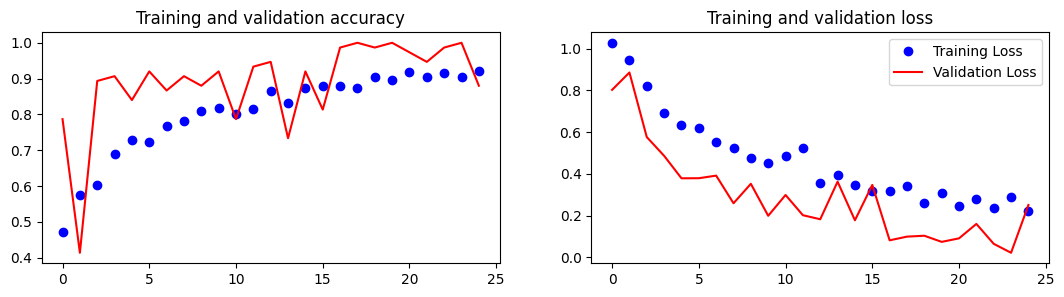

In [14]:
# Plotting the Accuracy and Loss
#
plot_loss_acc(history)

------------------
### <font color='brown'> Model Prediction </font>

------------------